In [1]:
import os
import copy

import numpy as np
import torch
import torch.nn as nn
import math

from torch import optim
from torch.utils.data import Dataset, DataLoader
from torch.nn import functional as F
from unet import UNet
from dice_loss import dice_coeff
####################################################
# for data splitting
####################################################
import pandas as pd
####################################################
# for data preparation
####################################################
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.metrics import roc_auc_score, accuracy_score, balanced_accuracy_score
####################################################
# for plotting
####################################################
import matplotlib.pyplot as plt
from IPython.display import clear_output
############################
# Helper func
############################
from helper import * 
###################################
TRAIN_RATIO = 0.8
RS = 30448
N_CHANNELS, N_CLASSES = 1, 1 
bilinear = True
BATCH_SIZE, EPOCHS = 16, 150
IMAGE_SIZE = (600, 600)
CROP_SIZE = (600, 600)

sss = StratifiedShuffleSplit(n_splits=1, test_size=1-TRAIN_RATIO, random_state=RS)

#There are 7 types of classes in the dataset for lesions as specified:
lesion_type_dict = {
    'seg': 'Segmentation', # 0
}
lesion_type_dict_malignant = {
    'seg': 'ben', # 0
}
#########################################
DIR = 'data/'

print()

In [2]:
import torch.multiprocessing
torch.multiprocessing.set_sharing_strategy('file_system')

In [3]:
import os
from sklearn.model_selection import train_test_split

CLIENTS = ['miccai', 'bns']
CLIENTS_2 = [cl + '_2' for cl in CLIENTS]
###################################################################
TOTAL_CLIENTS = len(CLIENTS)

DIR_DATA = 'data/imagesTrAug/'
DIR_GT = 'data/labelsTrBW/'

# Costruire una lista dei nomi dei file per ciascun nuovo dataset.
skin_dataset = dict()
skin_dataset['miccai'] = ['miccai_{:03d}'.format(i) for i in range(1, 201)]  # Nomi dei file per il dataset "miccai"
skin_dataset['bns'] = ['bns_{:03d}'.format(i) for i in range(1, 181)]  # Nomi dei file per il dataset "bns"

split_dataset = dict()
STATIC_WEIGHT = [0, 0]
order = 0

for client in skin_dataset:
    tmp = skin_dataset[client]
    x_ = [os.path.join(DIR_DATA, f + '.png') for f in tmp]
    y_ = [os.path.join(DIR_GT, f + '.png') for f in tmp]
    
    x_train, x_test, y_train, y_test = train_test_split(
        x_, y_, test_size=1 - TRAIN_RATIO, random_state=RS)

    split_dataset[client + '_train'] = Cancer(x_train, y_train, train=True, \
                                              IMAGE_SIZE=IMAGE_SIZE \
                                              , CROP_SIZE=CROP_SIZE)
    STATIC_WEIGHT[order] = len(x_train)
    order += 1

    split_dataset[client + '_test'] = Cancer(x_test, y_test, train=False, \
                                             IMAGE_SIZE=IMAGE_SIZE \
                                             , CROP_SIZE=CROP_SIZE)
    print(client)


miccai
bns


In [4]:
STATIC_WEIGHT = [item / sum(STATIC_WEIGHT) for item in STATIC_WEIGHT]
print(STATIC_WEIGHT)

[0.5263157894736842, 0.47368421052631576]


In [5]:
device = torch.device('cuda:0')
LR, WD, TH = 1e-3, 1e-4, 0.9
best_avg_acc, best_epoch = 0.0, 0

In [6]:
training_clients, testing_clients = dict(), dict()
training_clients_pl = dict()

acc_train, acc_test, loss_train, loss_test = dict(), dict(), \
                                            dict(), dict()
    
nets, optimizers = dict(), dict()

nets['global'] = UNet(n_channels=N_CHANNELS, n_classes=N_CLASSES, \
                      bilinear=True).to(device)

nets['global_2'] = UNet(n_channels=N_CHANNELS, n_classes=N_CLASSES, \
                      bilinear=True).to(device)

for client in CLIENTS:
    print(client)
    training_clients[client] = DataLoader(split_dataset[client+'_train'], batch_size=2,\
                 shuffle=True, num_workers=8)
    training_clients_pl[client] = DataLoader(split_dataset[client+'_train'], batch_size=1, \
                shuffle=True, num_workers=8)
    ###################################################################################
    testing_clients[client] = DataLoader(split_dataset[client+'_test'], batch_size=1,\
                         shuffle=False, num_workers=1)
    
    acc_train[client], acc_test[client] = [], []
    loss_train[client], loss_test[client] = [], []
        
    nets[client] = UNet(n_channels=N_CHANNELS, n_classes=N_CLASSES, \
                      bilinear=True).to(device)
    nets[client+'_2'] = UNet(n_channels=N_CHANNELS, n_classes=N_CLASSES, \
                      bilinear=True).to(device)
    optimizers[client]= optim.Adam(nets[client].parameters(), \
                                   lr=LR,weight_decay=WD)
    optimizers[client+'_2']= optim.Adam(nets[client+'_2'].parameters(), \
                                   lr=LR,weight_decay=WD)

miccai
bns


In [8]:
CLIENTS_SUPERVISION = ['labeled', 'labeled']
# CLIENTS_SUPERVISION = ['unlabeled', 'unlabeled', 'labeled', 'unlabeled']
# CLIENTS_SUPERVISION = ['bbox','bbox','labeled', 'bbox']

In [9]:
bbox_supervision = False

# FedAvg

In [10]:
CLIENTS_SUPERVISION = ['labeled', 'labeled']

In [11]:
WEIGHTS = STATIC_WEIGHT

Epoch: 149 / 150
Current Average Accuracy: 0.637274484605425 Best Average Accuracy: 0.6376915651063124


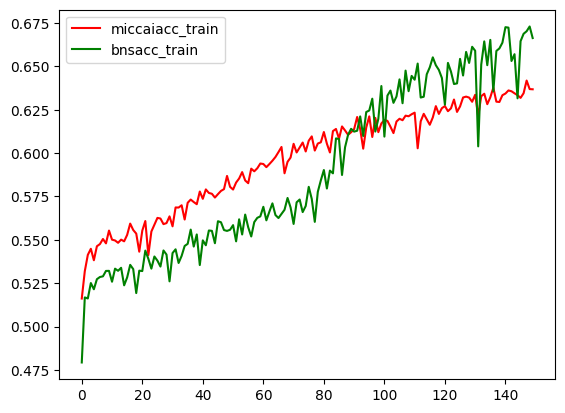

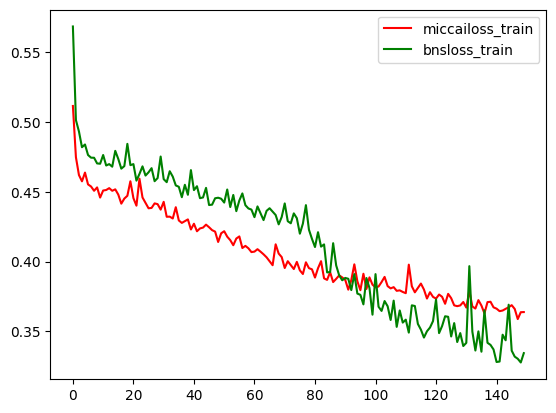

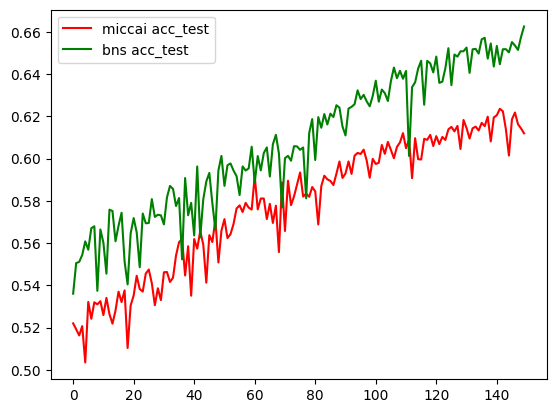

Best Average Accuracy: 0.6376915651063124 at Epoch: 146
miccai
shared epoch specific
0.6218286968767643
max client-specific
0.623590562492609
bns
shared epoch specific
0.6535544333358606
max client-specific
0.6625667119191753


In [13]:
import os
import torch

best_model_dir = "C:\\Users\\utente\\Desktop"
index = []  # Definizione della variabile index come una lista vuota
best_avg_acc, best_epoch_avg = 0, 0
best_models = {}  # Dizionario per memorizzare i migliori modelli per ciascun cliente

for epoch in range(EPOCHS):        
    index.append(epoch)
    
    #################### copy fed model ###################
    copy_fed(CLIENTS, nets, fed_name='global')
    
    #### conduct training #####
    for client, supervision_t in zip(CLIENTS, CLIENTS_SUPERVISION):
        train_model(training_clients[client], nets[client], \
                                  optimizers[client], device, \
                                  acc = acc_train[client], \
                                  loss = loss_train[client], \
                                  supervision_type = supervision_t)
        
    aggr_fed(CLIENTS, WEIGHTS, nets, fed_name='global')
    ################### test ##############################
    avg_acc = 0.0
    for client in CLIENTS:
        test(epoch, testing_clients[client], nets['global'], device, acc_test[client],\
             loss_test[client])
        avg_acc += acc_test[client][-1]
        # Salva il modello se l'accuratezza del cliente migliora
        if acc_test[client][-1] > best_models.get(client, {'accuracy': 0})['accuracy']:
            best_models[client] = {'model': nets[client].state_dict(), 'accuracy': acc_test[client][-1]}
            torch.save(nets[client].state_dict(), os.path.join(best_model_dir, f"best_model_{client}.pt"))
        
    avg_acc = avg_acc / TOTAL_CLIENTS
    ############################################################
    ########################################################
    if avg_acc > best_avg_acc:
        best_avg_acc = avg_acc
        best_epoch = epoch
    
    ################################
    # plot #########################
    ################################
    clear_output(wait=True)
    print("Epoch:", epoch, "/", EPOCHS)
    print("Current Average Accuracy:", avg_acc, "Best Average Accuracy:", best_avg_acc)
    plot_graphs(0, CLIENTS, index, acc_train, 'acc_train')
    plot_graphs(1, CLIENTS, index, loss_train, 'loss_train')
    plot_graphs(2, CLIENTS, index, acc_test, ' acc_test')

print("Best Average Accuracy:", best_avg_acc, "at Epoch:", best_epoch)
for client in CLIENTS:
    print(client)
    tmp = best_epoch
    best_epoch = best_epoch 
    print("shared epoch specific")
    print(acc_test[client][best_epoch])
    print("max client-specific")
    print(np.max(acc_test[client]))
    best_epoch = tmp


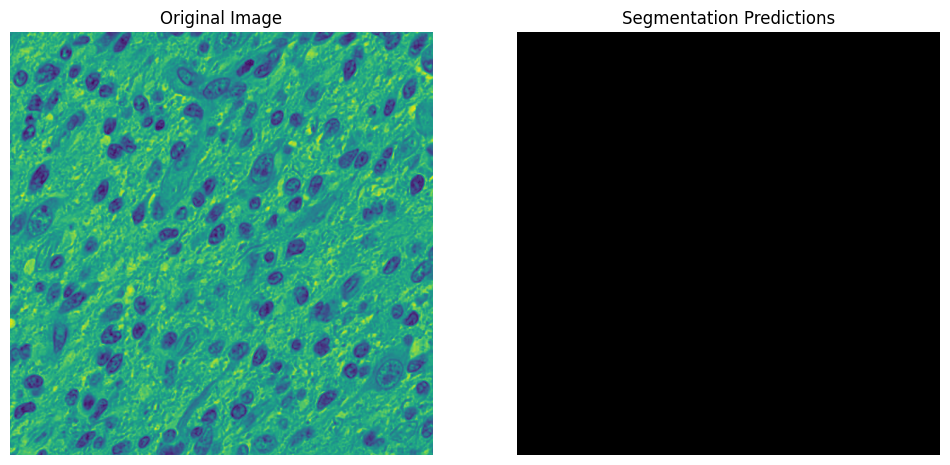

In [46]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torchvision.transforms as transforms


model = UNet(n_channels=N_CHANNELS, n_classes=N_CLASSES, bilinear=True).to(device)
model.load_state_dict(torch.load(r"C:\Users\utente\Desktop\best_model_miccai.pt"))
model.eval()

# Carica l'immagine di test
image_path = r"C:\Users\utente\Desktop\Università\Tesi magistrale\RC Nuclei Cellulari\RC_Nuclei\Nuclei_Segmentation_Experiments_Demo_dataset\MICCAI2017\Nuclei_segmentation_testing\imagesTs\image02.png"
image = Image.open(image_path)
image = image.convert('L')
# Applica le trasformazioni all'immagine di test
transform = transforms.Compose([
    transforms.ToTensor(),
    # Altre trasformazioni se necessario
])
input_image = transform(image).unsqueeze(0).to(device)  # Aggiungi una dimensione del batch

with torch.no_grad():
    output = model(input_image)

predictions = torch.argmax(output, dim=1).squeeze(0).cpu().numpy()

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(input_image.squeeze(0).permute(1, 2, 0).cpu().numpy())
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(predictions, cmap='gray')
plt.title('Segmentation Predictions')
plt.axis('off')

plt.show()
